# Data Ingestion for My Run Forecast

Loading in Garmin's .fit files and quick heart rate, pace, and elevation plots.

## Data Sources
### Input: 
.fit activity files from Garmin Connect.

.gpx route files from Strava.

### Output:
Parquet files containing the activity data.

In [1]:
import os, sys
from pathlib import Path

import numpy as np

# Add utils/ to path
cwd = Path.cwd()
for base in (cwd, cwd.parent, cwd.parent.parent):
    if (base / "utils").exists():
        sys.path.insert(0, str(base))
        break

from utils.features import create_elapsed_time, semicircle_to_degrees
from utils.fit import fit_to_df
from config import EXPECTED_FIT_COLUMNS, DATA_PATH, PLT_STYLE

routes_path = DATA_PATH

In [2]:
activity_file_name = sorted(
    [f for f in os.listdir(routes_path) if f.endswith('.fit')]
)[0]
print(f"Loading {activity_file_name}...")
df_1 = fit_to_df(routes_path + activity_file_name)

# Remove 'unknown' columns not in EXPECTED_FIT_COLUMNS
df_1 = df_1[[col for col in df_1.columns if col in EXPECTED_FIT_COLUMNS]]
df_1.head()

Loading 2025-06-30-15-07-06.fit...


,accumulated_power,activity_type,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,heart_rate,position_lat,position_long,power,stance_time,stance_time_balance,stance_time_percent,step_length,temperature,timestamp,vertical_oscillation,vertical_ratio
0,106,running,48,1.99,54.0,1.318,0.5,101,457455223,-1455557466,106,NaN,None,None,822.0,34,2025-06-30 22:07:06,57.9,7.05
1,198,running,48,3.91,54.0,1.318,0.5,100,457455161,-1455557734,92,NaN,None,None,822.0,34,2025-06-30 22:07:07,57.9,7.05
2,317,running,48,6.13,53.8,1.318,0.5,100,457455054,-1455558061,119,NaN,None,None,822.0,34,2025-06-30 22:07:08,57.9,7.05
3,467,running,48,8.69,53.6,1.318,0.5,100,457454958,-1455558381,150,NaN,None,None,1125.0,34,2025-06-30 22:07:09,61.9,5.50
4,616,running,48,11.54,53.6,1.802,0.5,100,457454792,-1455558667,149,NaN,None,None,1323.0,34,2025-06-30 22:07:10,64.4,4.87


## Basic Data Exploration

In [3]:
# Basic data info
print(f"Dataset shape: {df_1.shape}")
print("\nColumn names:")
print(df_1.columns.tolist())
print("\nData types:")
print(df_1.dtypes)

Dataset shape: (4658, 19)

Column names:
['accumulated_power', 'activity_type', 'cadence', 'distance', 'enhanced_altitude', 'enhanced_speed', 'fractional_cadence', 'heart_rate', 'position_lat', 'position_long', 'power', 'stance_time', 'stance_time_balance', 'stance_time_percent', 'step_length', 'temperature', 'timestamp', 'vertical_oscillation', 'vertical_ratio']

Data types:
accumulated_power                int64
activity_type                   object
cadence                          int64
distance                       float64
enhanced_altitude              float64
enhanced_speed                 float64
fractional_cadence             float64
heart_rate                       int64
position_lat                     int64
position_long                    int64
power                            int64
stance_time                    float64
stance_time_balance             object
stance_time_percent             object
step_length                    float64
temperature                      int

In [4]:
# Quick check for missing values
missing_data = df_1.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

Missing values per column:
stance_time             3041
stance_time_balance     4658
stance_time_percent     4658
step_length              929
vertical_oscillation     146
vertical_ratio           929
dtype: int64


This may seem alarming but features like `stance_time` and `step_length` may have missing values when in motion or stopped at rest. 

In [5]:
# Basic statistics for numeric columns
print("Basic statistics:")
print(df_1.describe())

Basic statistics:
       accumulated_power      cadence     distance  enhanced_altitude  \
count       4.658000e+03  4658.000000  4658.000000        4658.000000   
mean        5.592561e+05    59.425505  4288.118029         140.811249   
min         1.060000e+02     0.000000     1.990000          51.200000   
25%         3.036318e+05    51.000000  2240.080000          76.600000   
50%         5.383315e+05    55.000000  3890.575000         131.900000   
75%         8.525650e+05    77.000000  6740.125000         194.550000   
max         1.079569e+06   109.000000  9027.470000         292.800000   
std         3.150076e+05    16.799329  2654.424535          68.171048   

       enhanced_speed  fractional_cadence   heart_rate  position_lat  \
count     4658.000000         4658.000000  4658.000000  4.658000e+03   
mean         1.934871            0.304745   169.650279  4.573198e+08   
min          0.000000            0.000000   100.000000  4.571618e+08   
25%          1.339000            0.0

In [6]:
# GPS check
if 'position_lat' in df_1.columns and 'position_long' in df_1.columns:
    # Convert GPS coordinates from semicircles to degrees
    df_1['lat_deg'] = semicircle_to_degrees(df_1['position_lat'])
    df_1['long_deg'] = semicircle_to_degrees(df_1['position_long'])

    print(f"GPS data available: {df_1[['lat_deg', 'long_deg']].dropna().shape[0]} points")
    print(f"Lat range: {df_1['position_lat'].min():.4f} to {df_1['position_lat'].max():.4f}")
    print(f"Lon range: {df_1['position_long'].min():.4f} to {df_1['position_long'].max():.4f}")
else:
    print("No GPS data found")

GPS data available: 4658 points
Lat range: 457161837.0000 to 457458197.0000
Lon range: -1455643108.0000 to -1455427065.0000


In [7]:
df_1 = create_elapsed_time(df_1)

if 'enhanced_speed' in df_1.columns:
    # Convert from m/s to pace (min/mi)
    df_1['pace_min_mi'] = np.where(
        df_1['enhanced_speed'] > 0,
        (1609.34 / 60) / df_1['enhanced_speed'],
        np.nan
    )

print(f"\nDataFrame now has {df_1.shape[1]} columns")


DataFrame now has 23 columns


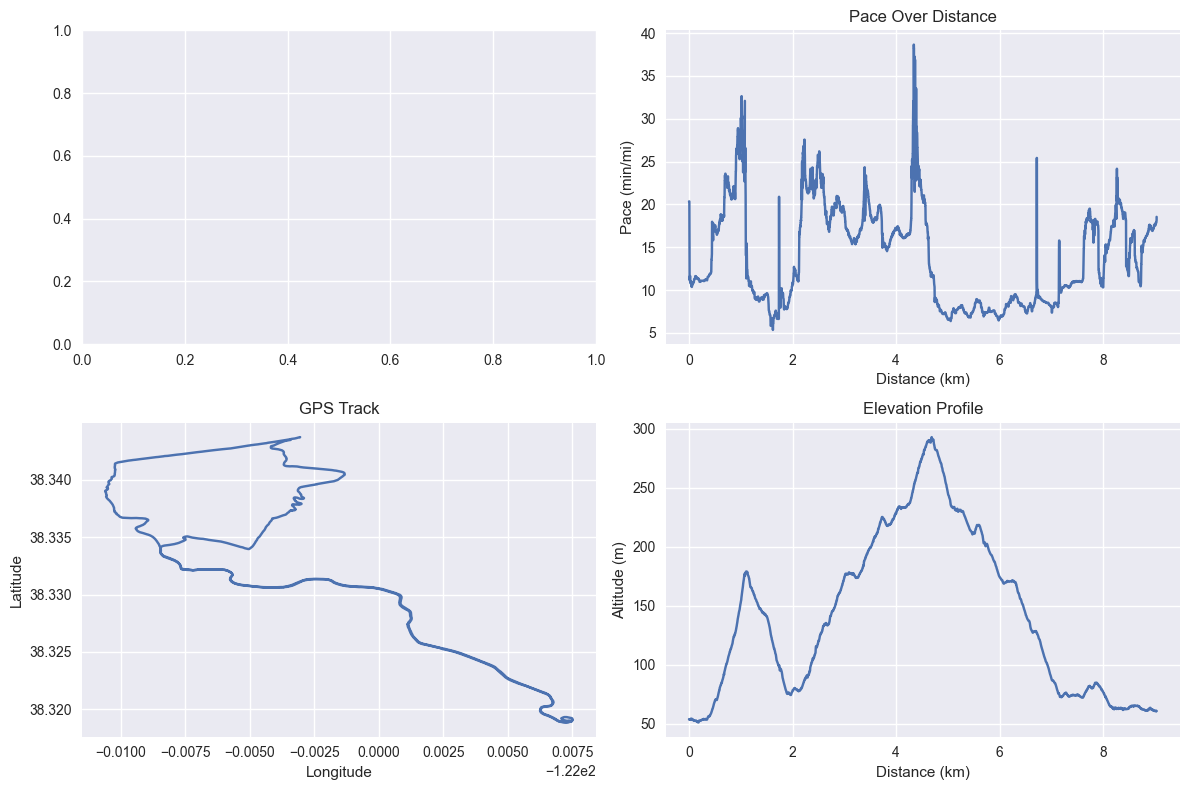

In [8]:
import matplotlib.pyplot as plt
plt.style.use(PLT_STYLE)

# Simple visualization to understand the data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Heart rate over time
if 'heart_rate' in df_1.columns and 'elapsed_time' in df_1.columns:
    axes[0,0].plot(df_1['elapsed_time']/60, df_1['heart_rate'])
    axes[0,0].set_title('Heart Rate Over Time')
    axes[0,0].set_xlabel('Time (minutes)')
    axes[0,0].set_ylabel('Heart Rate (bpm)')

# Speed/pace over time
if 'pace_min_mi' in df_1.columns and 'distance' in df_1.columns:
    axes[0,1].plot(df_1['distance']/1000, df_1['pace_min_mi'])
    axes[0,1].set_title('Pace Over Distance')
    axes[0,1].set_xlabel('Distance (km)')
    axes[0,1].set_ylabel('Pace (min/mi)')
# GPS track
if 'lat_deg' in df_1.columns and 'long_deg' in df_1.columns:
    axes[1,0].plot(df_1['long_deg'], df_1['lat_deg'])
    axes[1,0].set_title('GPS Track')
    axes[1,0].set_xlabel('Longitude')
    axes[1,0].set_ylabel('Latitude')

# Elevation profile
if 'enhanced_altitude' in df_1.columns and 'distance' in df_1.columns:
    axes[1,1].plot(df_1['distance']/1000, df_1['enhanced_altitude'])
    axes[1,1].set_title('Elevation Profile')
    axes[1,1].set_xlabel('Distance (km)')
    axes[1,1].set_ylabel('Altitude (m)')

plt.tight_layout()
plt.show()

In [9]:
# Save full data to parquet
df_1.to_parquet(
    routes_path + activity_file_name.replace(".fit", ".parquet"),
    index=False
)